<a href="https://colab.research.google.com/github/Mafaz03/Autoencoder/blob/main/Learner_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [2]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
from torch.utils.data import default_collate
from typing import Mapping
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc



def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

# %% ../nbs/05_datasets.ipynb 33
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

# %% ../nbs/05_datasets.ipynb 37
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

# %% ../nbs/05_datasets.ipynb 41
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

# %% ../nbs/05_datasets.ipynb 45
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

# %% ../nbs/05_datasets.ipynb 47
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

# %% ../nbs/05_datasets.ipynb 51
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [4]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [5]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00


In [6]:
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F


import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
import logging
from fastcore.test import test_close

In [7]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [8]:

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
logging.disable(logging.WARNING)

In [10]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [12]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [13]:
bs = 1024
tds = dsd.with_transform(transformi)

In [14]:
iter

<function iter>

In [15]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

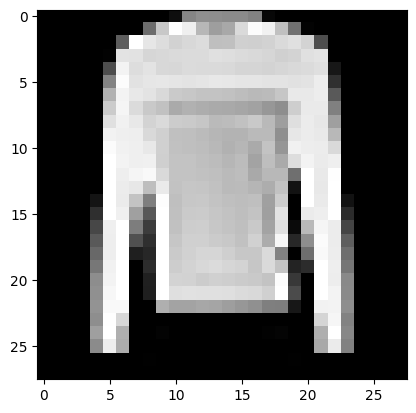

In [16]:
plt.imshow(xb[21].reshape(-1,28,28).permute(1,2,0))

In [17]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl):
          self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)

    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(train = True)
            with torch.no_grad(): self.one_epoch(False)

In [18]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [19]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
# learn.fit(5)

In [20]:
accs, losses, ns = [], [], []
model.to(def_device)
opt = optim.SGD(model.parameters(), 0.001)

In [21]:
epochs = 1
accuracy = []
losses = []

for epoch in range(epochs):
  model.training = True
  dl = dls.train
  for iterr, batch in enumerate(dl):
    xb, yb = to_device(batch)
    pred = model(xb)
    loss = F.cross_entropy(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
    acc = (pred.argmax(dim = 1) == yb).float().sum()

    accuracy.append(float(acc))
    losses.append(float(loss))
  print(sum(accuracy)/batch[1].shape[0], sum(losses)/batch[1].shape[0])

12.162828947368421 0.22370980915270353


In [22]:
# plt.plot(accuracy)

In [23]:
# plt.plot(losses)

In [24]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [25]:
class Callback(): order = 0

In [26]:
def run_cbs(cbs, method_nm, iter_count = None, dothis=None):
  for cb in sorted(cbs, key=attrgetter('order')):
    method = getattr(cb, method_nm, None)
    if iter_count is not None and method is not None:
      method(dothis, iter_count)
    if iter_count is None:
      method(dothis)


In [27]:
class CompletionCB(Callback):
  def before_fit(self, dothis):
    print("-> Hello from CompletionCB, doing before fit")
    self.count = 0
  def after_batch(self, dothis):
    print("-> Hello from CompletionCB, doing after batch")
    self.count += 1
  def after_fit(self, learn):
    print(f'Completed {self.count} batches')

In [28]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

-> Hello from CompletionCB, doing before fit
-> Hello from CompletionCB, doing after batch
Completed 1 batches


In [29]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            print("Guess i am doing before_epoch now :|")
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    print("Guess i am doing before_batch now :|")
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    print("CancelBatchException :((")
                    pass
            self.callback('after_epoch', self.iter)  # Pass iter_count to after_epoch
            print("Guess i am doing after_epoch now :|")
        except CancelEpochException:
            print("CancelEpochException :((")
            pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.iter = 0
            self.callback('before_fit', self.iter)  # Pass iter_count to before_fit
            print("Guess i am doing before_fit now :|")
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit', self.iter)  # Pass iter_count to after_fit
            print("Guess i am doing after_fit now :|")
        except CancelFitException:
            print("CancelFitException :((")
            pass

    def callback(self, method_nm, iter_count):
        run_cbs(self.cbs, method_nm, dothis = self, iter_count = iter_count)



In [30]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [31]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, dothis): raise CancelFitException()


In [32]:
class Metric:
  def __init__(self): self.reset()
  def reset(self): self.val, self.ns = [], []
  def add(self, inp, targ=None, n=1):
    self.last = inp
    self.val.append(self.last)
    self.ns.append(n)
  @property
  def value(self):
    ns = tensor(self.ns)
    return (tensor(self.val)*ns).sum()/ns.sum()
  def calc(self, inps, targs):
    return inps
    print("Right now its doing nothing")

In [33]:
class Accuracy(Metric):
  def calc(self, inps, targs):
    return (inps == targs).float().mean()

In [34]:
ac = Accuracy()
ac.add(1,3)
ac.add(32,3)

In [35]:
ac.value

tensor(16.50)

In [36]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [37]:
def run_cbs(cbs, method_nm, iter_count = None, dothis=None):
  for cb in sorted(cbs, key=attrgetter('order')):
    method = getattr(cb, method_nm, None)
    if iter_count is not None and method is not None:
      method(dothis, iter_count)
    if iter_count is None:
      method(dothis)


In [38]:

#|export
class MetricsCB(Callback):
    order = 0
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn, iter_count): learn.metrics = self
    def before_epoch(self, learn, iter_count): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn, iter):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        log['itteration'] = self.iter
        self._log(log)

    def after_batch(self, learn, iter_count):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [39]:
class DontExceed(Callback):

  order = 1
  def __init__(self, epoch): self.epoch = epoch
  def before_fit(self, dothis, iter_count):
    self.epoch_ = 0

  def after_batch(self, dothis, iter_count):
    self.epoch_ += 0
    if self.epoch_ == self.epoch:
      raise CancelFitException()


In [40]:
def to_cpu(x):
  if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
  if isinstance(x, list): return [to_cpu(o) for o in x]
  if isinstance(x, tuple): return tuple(to_cpu(list(x)))
  res = x.detach().cpu()
  return res.float() if res.dtype==torch.float16 else res

In [41]:
def run_cbs1(cbs, method_nm, iter_count = None, dothis=None):
  for cb in sorted(cbs, key=attrgetter('order')):
    method = getattr(cb, method_nm, None)
    if method is not None:
      if iter_count is not None:
        method(dothis, iter_count)
      else:
        method(dothis)

In [42]:
class Learner():
    order = 0
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.final_iter = 1  # Initialize final_iter
            self.callback('before_epoch', self.iter)
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch', self.iter)
                    self.one_batch()
                    self.callback('after_batch', self.iter)
                    self.final_iter = self.iter
                except CancelBatchException:
                    print("CancelBatchException :((")

            self.callback('after_epoch', self.final_iter)  # Pass final_iter to after_epoch
        except CancelEpochException:
            print("CancelEpochException :((")
            pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.iter = 0
            self.callback('before_fit', self.iter)
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit', self.iter)  # Pass iter_count to after_fit
        except CancelFitException:
            self.callback('Canceled', self.iter)
            print("CancelFitException :((")
            pass

    def callback(self, method_nm, iter_count):
        run_cbs1(self.cbs, method_nm, iter_count=iter_count, dothis=self)


In [ ]:

#|export
class MetricsCB(Callback):
    order = 0
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn, iter_count):
      learn.metrics = self
    def before_epoch(self, learn, iter_count): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn, iter):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        log['iteration'] = iter
        self._log(log)

    def after_batch(self, learn, iter_count):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [118]:
class PrintLOL(Callback):
  order = MetricsCB2.order + 1

  def Canceled(self, thiswillalsowork, iter_count):
    print(thiswillalsowork.batch[0].shape)
    print("You are canceled :(")
  def before_epoch(self, thiswillalsowork, iter_count):
    print("Epoch Started")

  # def before_batch(self, thiswillalsowork, iter_count):
  #   print("Batch Started")
  # def after_batch(self, thiswillalsowork, iter_count):
  #   print("Batch Completed")
  def after_epoch(self, thiswillalsowork, iter_count):
    print("Epoch completed")

In [45]:
MetricsCB.order

0

In [46]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[PrintLOL(), MetricsCB(), DontExceed(0)])
learn.fit(2)

Epoch Started
torch.Size([1024, 784])
You are canceled :(
CancelFitException :((


In [110]:
def run_cbs2(cbs, method_nm, dothis=None):
  for cb in sorted(cbs, key=attrgetter('order')):
    method = getattr(cb, method_nm, None)
    if method is not None:
        method(dothis)

In [114]:
class Learner():

  def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
      fc.store_attr()

  @contextmanager
  def cb_ctx(self, nm):
    try:
      self.callback(f'before_{nm}')
      yield
      self.callback(f'after_{nm}')
    except globals()[f'Cancel{nm.title()}Exception']:
      print(f'Cancel{nm.title()}Exception :((')

  def one_batch(self):
    self.preds = self.model(self.batch[0])
    self.loss = self.loss_func(self.preds, self.batch[1])
    if self.model.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  def one_epoch(self, train):
    self.model.train(train)
    self.dl = self.dls.train if train else self.dls.valid

    with self.cb_ctx('epoch'):
      for self.iter, self.batch in enumerate(self.dl):
        with self.cb_ctx('batch'):
          self.predict()
          self.get_loss()
          if self.training:
            self.backward()
            self.step()
            self.zero_grad()

  def fit(self, n_epochs):
    # self.n_epochs()
    # self.epochs = range(n_epochs)

    self.n_epochs = n_epochs
    self.epochs = range(n_epochs)
    self.opt = self.opt_func(self.model.parameters())
    self.iter = 0
    with self.cb_ctx('fit'):
      for self.epoch in self.epochs:
        self.one_epoch(True)
        self.one_epoch(False)


  def __getattr__(self, name):
    if name in ('predict','get_loss','backward','step','zero_grad', 'opt', 'iter'): return partial(self.callback, name)
    raise AttributeError(name)

  @property
  def training(self): return self.model.training

  def callback(self, method_nm):
    run_cbs2(self.cbs, method_nm, dothis=self)



In [112]:
class TrainCB(Callback):
  def __init__(self, n_inp=1): self.n_inp = n_inp
  def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
  def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
  def backward(self, learn): learn.loss.backward()
  def step(self, learn): learn.opt.step()
  def zero_grad(self, learn): learn.opt.zero_grad()

In [121]:

#|export
class MetricsCB2(Callback):
    order = 0
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn):
      learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [122]:
model = get_model()
metrics = MetricsCB2(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)


{'accuracy': '0.158', 'loss': '2.276', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.179', 'loss': '2.264', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.190', 'loss': '2.253', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.210', 'loss': '2.241', 'epoch': 1, 'train': 'eval'}


In [51]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training